In [1]:
!pip install -q gradio opencv-python matplotlib seaborn scikit-learn joblib

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
import zipfile
import os

with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("/content/")

In [4]:
dataset_path = "/content/Brain_Data_Organised"
stroke_dir = os.path.join(dataset_path, "Stroke")
normal_dir = os.path.join(dataset_path, "Normal")

In [5]:
def load_images(folder, label, img_size=(224, 224), grayscale=False):
    images, labels = [], []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, img_size).flatten()
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
        images.append(img)
        labels.append(label)
    return images, labels

In [6]:
#CNN Data
stroke_images_rgb, stroke_labels = load_images(stroke_dir, 1)
normal_images_rgb, normal_labels = load_images(normal_dir, 0)
X_cnn = np.array(stroke_images_rgb + normal_images_rgb)
y = np.array(stroke_labels + normal_labels)
X_cnn = X_cnn / 255.0
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y)

In [7]:
# Extract features using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract feature vectors for SVM
X_features = feature_extractor.predict(X_cnn)
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_features, y, test_size=0.2, stratify=y)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step


In [8]:
# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Train CNN
es = EarlyStopping(patience=3, restore_best_weights=True)
cnn_model.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test),
              epochs=10, callbacks=[es])

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.6117 - loss: 1.4604 - val_accuracy: 0.8483 - val_loss: 0.3721
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8717 - loss: 0.3071 - val_accuracy: 0.9521 - val_loss: 0.1488
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9508 - loss: 0.1209 - val_accuracy: 0.9621 - val_loss: 0.0973
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9768 - loss: 0.0648 - val_accuracy: 0.9820 - val_loss: 0.0576
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9878 - loss: 0.0356 - val_accuracy: 0.9760 - val_loss: 0.0569
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9946 - loss: 0.0197 - val_accuracy: 0.9741 - val_loss: 0.0649
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9919 - loss: 0.0218 - val_accuracy: 0.9800 - val_loss: 0.0456
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9968 - loss: 0.0143 - val_accuracy: 0.9760 

In [12]:
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       311
           1       0.95      0.99      0.97       190

    accuracy                           0.98       501
   macro avg       0.98      0.98      0.98       501
weighted avg       0.98      0.98      0.98       501



In [13]:
# Train SVM on extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_feat, y_train_feat)

SVC(kernel='linear', probability=True)

In [14]:
y_pred_svm = svm_model.predict(X_test_feat)
print("SVM Classification Report:\\n", classification_report(y_test_feat, y_pred_svm))

SVM Classification Report:\n               precision    recall  f1-score   support

           0       0.81      0.83      0.82       311
           1       0.71      0.68      0.70       190

    accuracy                           0.78       501
   macro avg       0.76      0.76      0.76       501
weighted avg       0.77      0.78      0.78       501



In [15]:
cnn_model.save("cnn_stroke_model.h5")
joblib.dump(svm_model, "svm_stroke_model.pkl")

['svm_stroke_model.pkl']

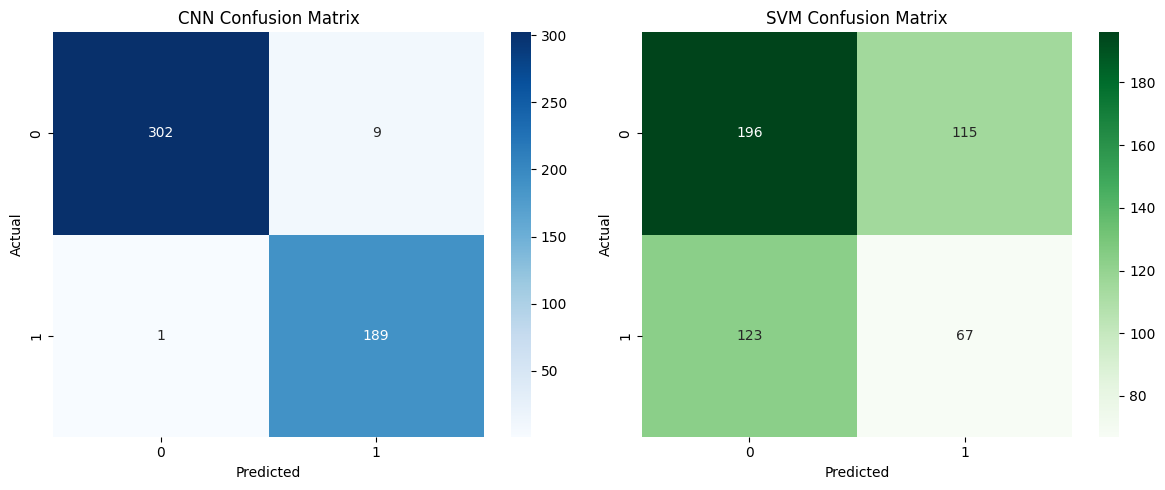

In [16]:
labels = ['Normal', 'Stroke']
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


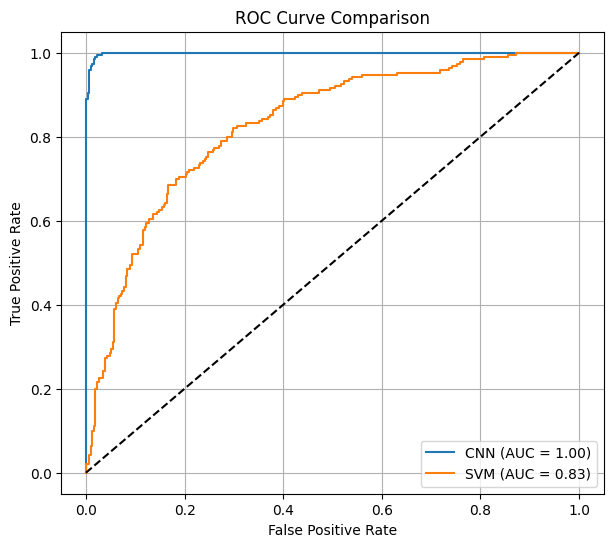

In [20]:
from sklearn.metrics import roc_curve, auc

# CNN AUC
y_pred_cnn_proba = cnn_model.predict(X_test_cnn).ravel()
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_proba)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# SVM AUC
y_pred_svm_proba = svm_model.predict_proba(X_test_feat)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_feat, y_pred_svm_proba)
auc_svm = auc(fpr_svm, tpr_svm)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {auc_cnn:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


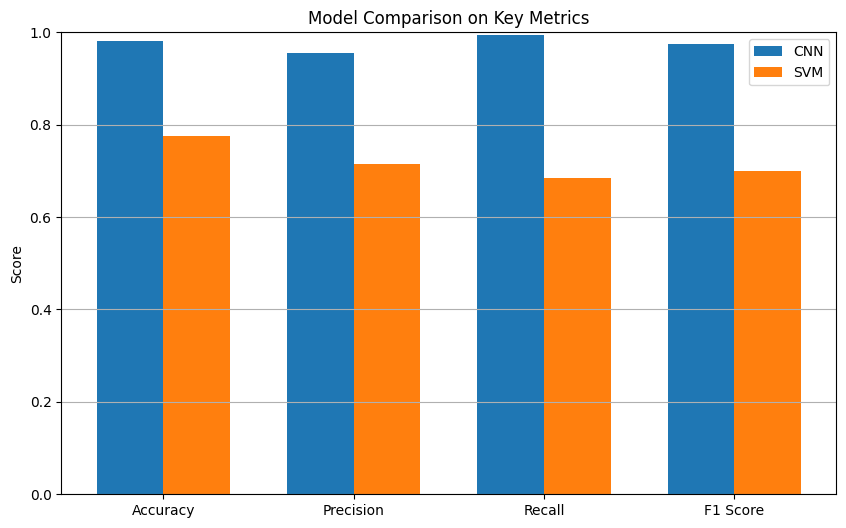

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# CNN metrics
cnn_acc = accuracy_score(y_test, y_pred_cnn)
cnn_prec = precision_score(y_test, y_pred_cnn)
cnn_rec = recall_score(y_test, y_pred_cnn)
cnn_f1 = f1_score(y_test, y_pred_cnn)

# SVM metrics
svm_acc = accuracy_score(y_test_feat, y_pred_svm)
svm_prec = precision_score(y_test_feat, y_pred_svm)
svm_rec = recall_score(y_test_feat, y_pred_svm)
svm_f1 = f1_score(y_test_feat, y_pred_svm)

# Plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cnn_values = [cnn_acc, cnn_prec, cnn_rec, cnn_f1]
svm_values = [svm_acc, svm_prec, svm_rec, svm_f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, cnn_values, width, label='CNN')
plt.bar(x + width/2, svm_values, width, label='SVM')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Model Comparison on Key Metrics')
plt.legend()
plt.grid(True, axis='y')
plt.show()


In [18]:
# Gradio UI
def predict(image, model_type):
    img = cv2.resize(image, (224, 224))
    if model_type == "CNN":
        img_rgb = img[..., :3] / 255.0
        pred = cnn_model.predict(np.expand_dims(img_rgb, axis=0))[0][0]
    else:
        img_rgb = cv2.resize(image, (224, 224))
        img_rgb = preprocess_input(img_rgb.astype('float32'))
        feature = feature_extractor.predict(np.expand_dims(img_rgb, axis=0))
        pred = svm_model.predict_proba(feature)[0][1]
    return {"Stroke": float(pred), "Normal": float(1 - pred)}

iface = gr.Interface(
    fn=predict,
    inputs=[gr.Image(type="numpy"), gr.Radio(["CNN", "SVM"], label="Model")],
    outputs=gr.Label(num_top_classes=2),
    title="Brain Stroke Detection",
    description="Upload a brain scan and select model to predict stroke presence."
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://acf7c324e971e2b13d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
